## Secrets in bilibili video covers:
    Work on the videos in the bilibili hot list to take insights into the connection between the thumbnail image styles and the genres of these videos!

### Work Flow:
Pictures ->(1) Feature Vectors ->(2) Dis/Similarity Matrix ->(3) Graph ->(4) Community ->(5) Visualization ->(6) Analysis

In [1]:
import feature
import palsgraph
import networkx as nx
import numpy as np
import scipy as sc
import itertools
import matplotlib.pyplot as plt
import feature2graph
from scipy.spatial.distance import cdist,squareform
# import area for every member to add their source code

In [2]:
# parameters
#categories = ['animal','animation','dance','fashion','food','game','kichiku','knowledge','life','music','tech']
categories = ['animal','dance','food']
num_train_per_cat = 5
num_pictures = len(categories)*num_train_per_cat
data_path = './M2_test/'

#### (1）HOG and Yolov3 to extract features
Input: pictures or their paths. Output: Feature Vectors possibly

In [3]:
# load data
image_paths,labels,genres = feature.get_image_paths(data_path, categories, num_train_per_cat)
# get feature vectors using different methods
features = feature.get_feature_hog(image_paths)   # using hog to extract 

objects = feature2graph.read_features(num_pictures)
elements = ['person','animal','food','other']
vectors = feature2graph.get_vectors(objects, elements)

#### (2) Covariance/ Euclidean Distance/Gaussian to get Dis/Similarity Matrix
Input: featurer vectors.Output: dis/simlarity matrix.

if step(1) has directly got the output, then jump to the next step.

In [4]:
# using Euclidean distance to calculate distance/similarity
# distance = feature.get_distance(features,num_pictures) 

distance = feature.get_distance(vectors,num_pictures)
print(distance)

[[0.         1.         2.44948974 1.         1.73205081 1.41421356
  2.64575131 0.         1.         1.         1.73205081 2.23606798
  1.41421356 2.44948974 2.23606798]
 [1.         0.         2.23606798 2.         1.41421356 1.73205081
  3.16227766 1.         2.         2.         2.         2.44948974
  1.73205081 2.64575131 2.44948974]
 [2.44948974 2.23606798 0.         3.         2.23606798 3.16227766
  2.23606798 2.44948974 3.         3.         2.64575131 2.23606798
  2.44948974 2.44948974 2.23606798]
 [1.         2.         3.         0.         2.44948974 1.73205081
  2.44948974 1.         0.         0.         2.         2.44948974
  1.73205081 2.64575131 2.44948974]
 [1.73205081 1.41421356 2.23606798 2.44948974 0.         2.23606798
  2.82842712 1.73205081 2.44948974 2.44948974 2.44948974 3.16227766
  2.64575131 3.         3.16227766]
 [1.41421356 1.73205081 3.16227766 1.73205081 2.23606798 0.
  3.         1.41421356 1.73205081 1.73205081 1.         2.23606798
  1.41421356

#### (3) Threshold or some other ways
Input: dis/similarity matrix.
Output: different ways to describe a graph.

some code in Kal's homework may help to find the appropriate threshold.(show the histogram of the data,and then test)

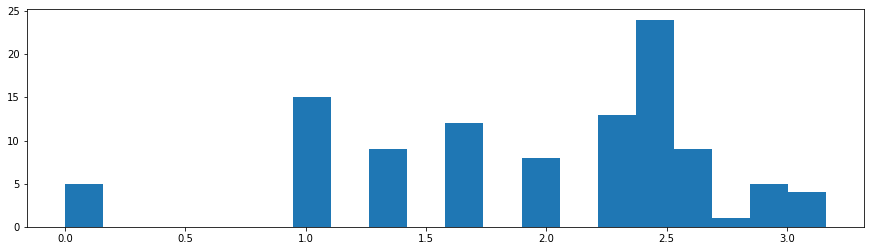

In [5]:
# homework code to visualize similarity matrix in histogram
plt.figure(figsize=(15, 4))
_ = plt.hist(squareform(distance), bins=20)


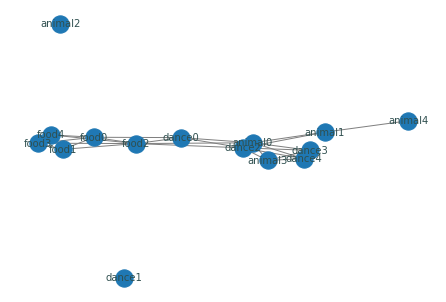

In [6]:
threshold = 1.5  # waiting to be tested
adjmat = feature.get_graph(distance,threshold)
feature.write_edgestxt(num_pictures,adjmat)   # write edges information into a txt file
# help to visualize graph for a simple look
G = palsgraph.make_graph(adjmat, labels=labels, show_singletons=True)
nx.draw(G, with_labels=True,font_size=10,font_color='darkslategray',edge_color='gray')

**Perform the clustering**

#### (4) Different Community Detection Algorithms
Input: graph. Output: community in a graph


**Lode data from file**


In [7]:
# #Bruce: using data from the edge.tat file


# edges = np.array([(str(x), str(y)) for (x, y) in np.genfromtxt('../Documents/GitHub/CD-02/edges.txt', delimiter=' ', dtype=np.integer)])

# # Convert the names of the vertices into matrix indices, and vice versa
# idx2node = dict(list(enumerate(np.unique(edges.reshape(-1,)))))
# node2idx = {str(v): k for k, v in idx2node.items()}
# adjlabels=labels
# #adjlabels = [idx2node[idx] for idx in range(len(idx2node))]

# size = len(idx2node.keys())
# adjmat = np.zeros((size, size))
# for i in range(edges.shape[0]):
#     adjmat[node2idx[edges[i,0]], node2idx[edges[i,1]]] = adjmat[node2idx[edges[i,1]], node2idx[edges[i,0]]] = 1
    
# adjG = palsgraph.make_graph(adjmat, labels=adjlabels, show_singletons=False)

**process data from the part above provided by Tingyu**

In [8]:
idx2node=dict(list(enumerate( labels)))
node2idx = {str(v): k for k, v in idx2node.items()}
adjlabels=labels


##### Girvan-Newman
Girvan-Newman accepts an unweighted graph as input. Hence, we load the file  𝚎𝚍𝚐𝚎𝚜.𝚝𝚡𝚝 , which contains a list of unweighted edges, and translate it into an adjacency matrix.


In [9]:
from networkx.algorithms.community.centrality import girvan_newman

comp = girvan_newman(G)

gn_communities = [c for c in itertools.islice(comp, 1)][0]

#### MCL algorithm


In [10]:
import markov_clustering as mc

def restore_labels(communities, idx2node):
    _communities = []
    for community in communities:
        _communities.append([idx2node[idx] for idx in community])
    return _communities

matrix = nx.to_scipy_sparse_matrix(G)

result = mc.run_mcl(matrix)
mcl_communities = mc.get_clusters(result)
mcl_communities = restore_labels(mcl_communities, idx2node)

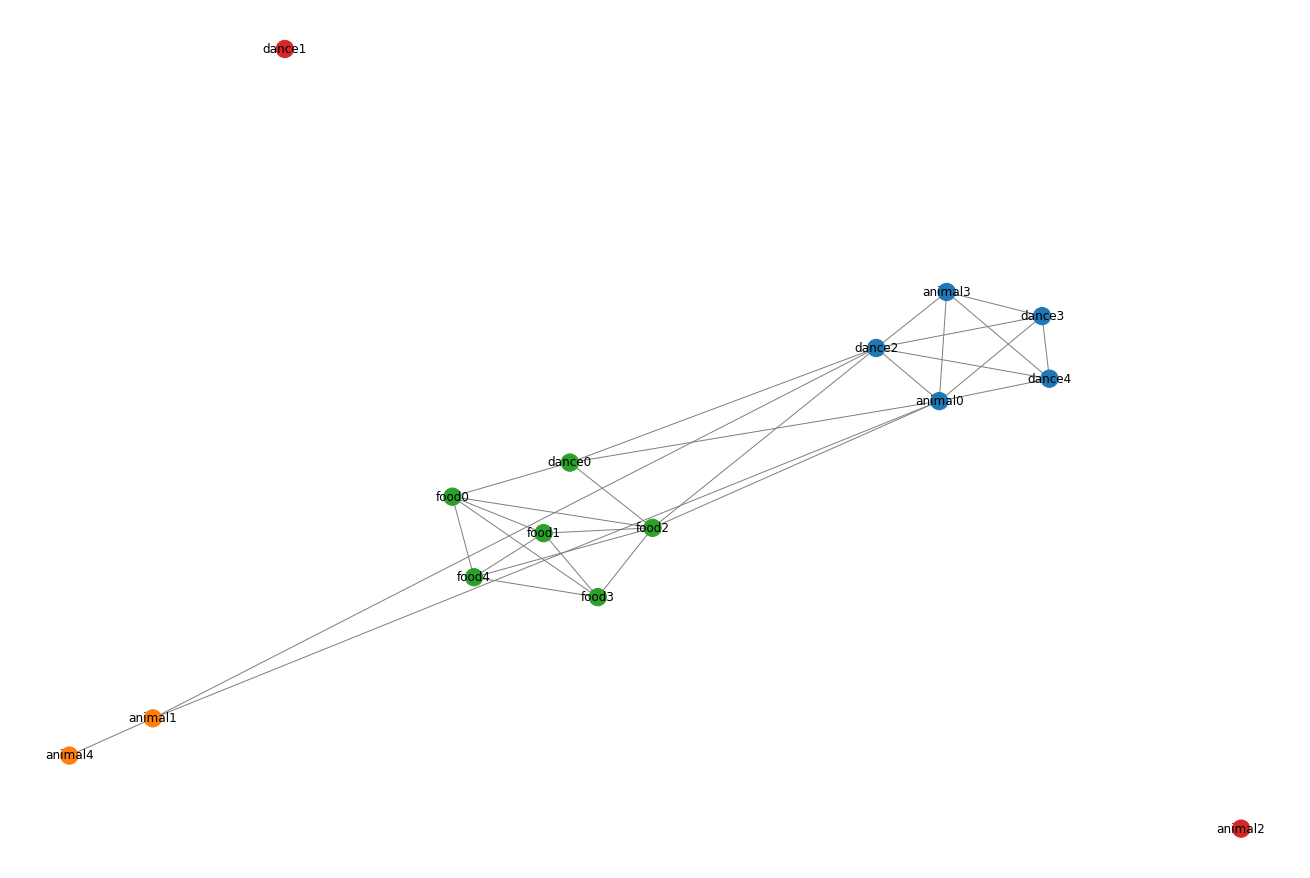

In [11]:

pos = palsgraph.getpos(G, mcl_communities)
color_map = palsgraph.gen_colormap(G, mcl_communities)
plt.figure(figsize=(18, 12))
nx.draw(G, pos=pos, with_labels=True, node_color=color_map, edge_color='grey')
plt.show()

##### Single-Linkage Clustering
using the code prof.Kal provides 

input: distance matrix and node label list

In [12]:
#Bruce: using the distance Tingyu provided as distance matrix, labels as the label list
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

linkages = linkage(squareform(distance), 'single')

**Visualize dendogram**

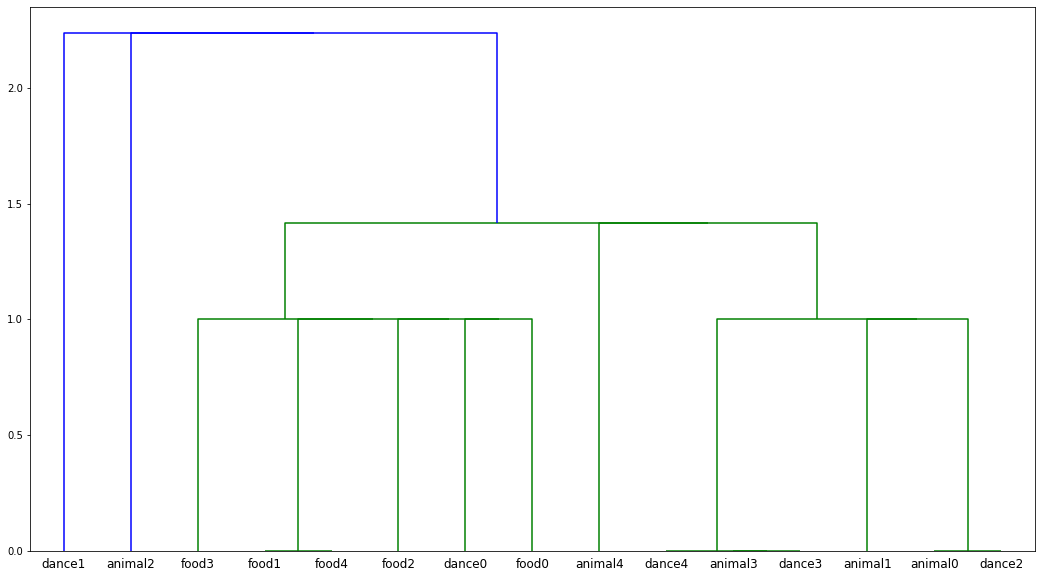

In [13]:
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(18, 10))
dn = dendrogram(linkages, labels=labels)
plt.show()

##### Clique Perculation
needed input: unweighted graph 

In [14]:
#Bruce:use unweighted graph G
from networkx.algorithms.community.kclique import k_clique_communities

def get_communities(C):
    communities = []
    nodes = []
    for community in list(C):
        communities.append(list(community))
        nodes.extend(list(community))
    _G = G.copy()
    nodes_to_remove = [node for node in _G.nodes() if node not in nodes]
    for node in nodes_to_remove:
        _G.remove_node(node)        
    return communities, _G

C = k_clique_communities(G, 5)
cp_communities, cp_G = get_communities(C)

**visualize clique**

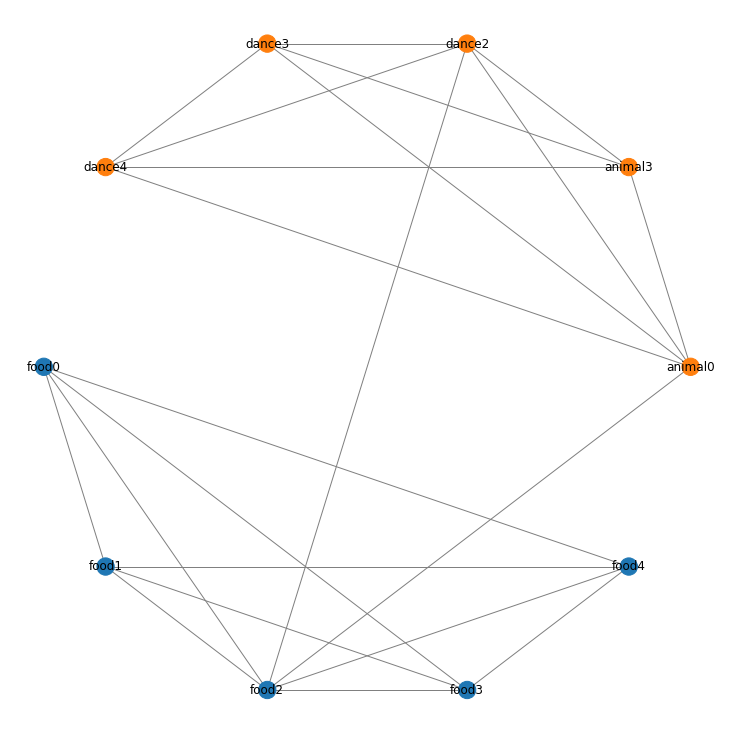

In [15]:
plt.figure(figsize=(10, 10))
color_map = palsgraph.gen_colormap(cp_G, cp_communities)
nx.draw(cp_G, pos=nx.circular_layout(cp_G), node_color=color_map, edge_color='grey', with_labels=True)

#### (5) Visualization
Input: community above. Output: different visualizations

**visualization of Girvan-Newman algorithm**

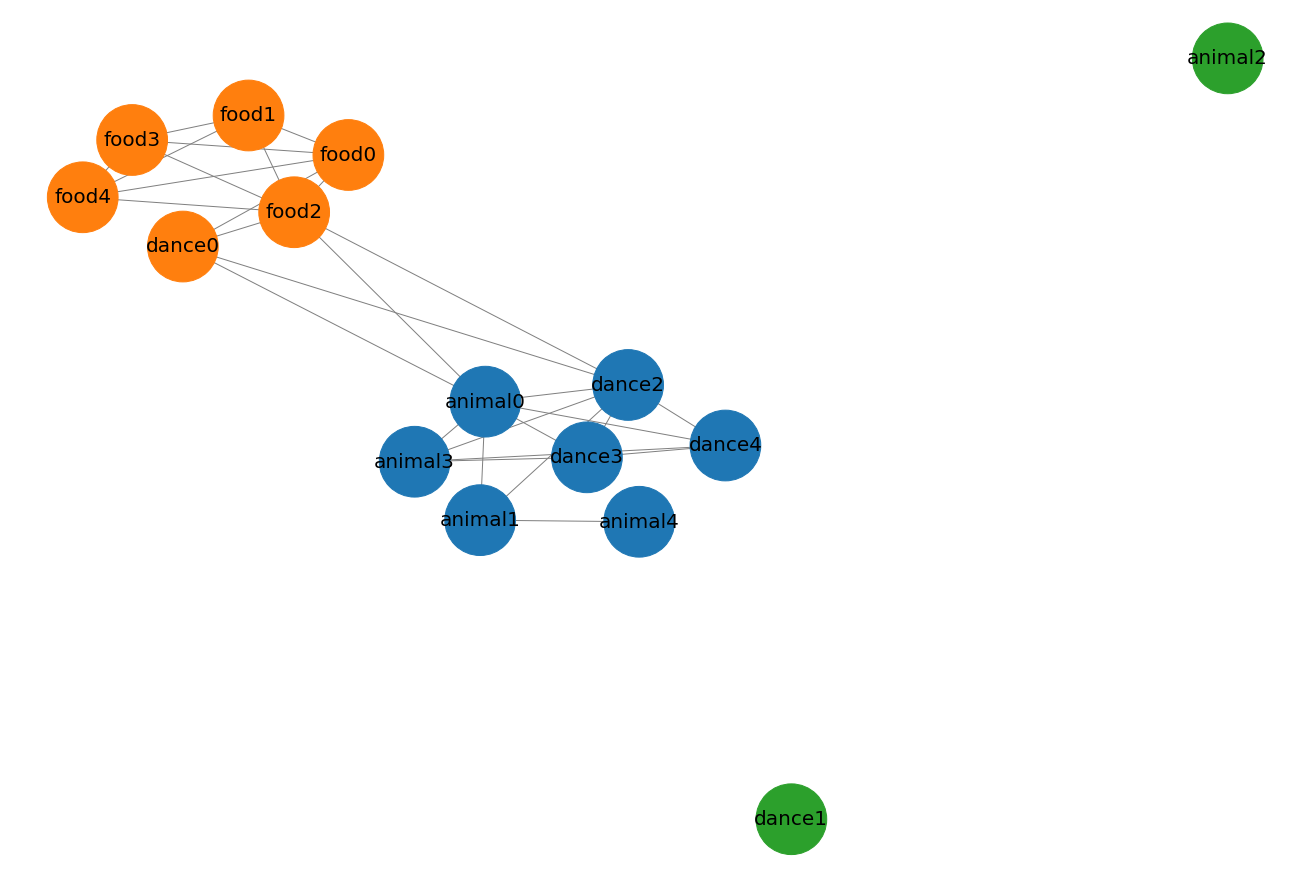

In [16]:
pos = palsgraph.getpos(G, gn_communities)
color_map = palsgraph.gen_colormap(G, gn_communities)
plt.figure(figsize=(18, 12))
nx.draw(G,node_size=5000, pos=pos, with_labels=True, node_color=color_map, font_size=20,font_color='black', edge_color='grey')
plt.show()

#### (6) Analysis 
(I am not sure about whether this part needs any code or something else to help)